<a href="https://colab.research.google.com/github/corderobot/Kaggle_HousePrices/blob/master/NNs/HousePrices_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importaciones de Librerías

In [2]:
%tensorflow_version 2.x
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Dropout

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dataset

## Extrayendo Dataset de Train y Test

In [0]:
train = pd.read_csv('https://raw.githubusercontent.com/corderobot/Kaggle_HousePrices/master/CSVs/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/corderobot/Kaggle_HousePrices/master/CSVs/test.csv')

# Dropping Id Column on both
IdPreds = test['Id']
target = train['SalePrice']

len_train = len(train)
train = train.drop(columns=['Id', 'SalePrice'])
test = test.drop(columns=['Id'])


### Conociendo el Dataset de Train

In [4]:
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1456,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1457,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
1458,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0

### Conociendo el Dataset de Test

In [5]:
test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GL


### Combinando Datasets

In [6]:
# Combinamos los Datasets para lidiar con todos los valores nulos
combined = pd.concat((train, test)).reset_index(drop=True)
combined

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Un

## Analisis de Missing Values o NAs

MSZoning  has total of NaNs:		 4 	out of:	 2919
LotFrontage  has total of NaNs:		 486 	out of:	 2919
Alley  has total of NaNs:		 2721 	out of:	 2919
Utilities  has total of NaNs:		 2 	out of:	 2919
Exterior1st  has total of NaNs:		 1 	out of:	 2919
Exterior2nd  has total of NaNs:		 1 	out of:	 2919
MasVnrType  has total of NaNs:		 24 	out of:	 2919
MasVnrArea  has total of NaNs:		 23 	out of:	 2919
BsmtQual  has total of NaNs:		 81 	out of:	 2919
BsmtCond  has total of NaNs:		 82 	out of:	 2919
BsmtExposure  has total of NaNs:		 82 	out of:	 2919
BsmtFinType1  has total of NaNs:		 79 	out of:	 2919
BsmtFinSF1  has total of NaNs:		 1 	out of:	 2919
BsmtFinType2  has total of NaNs:		 80 	out of:	 2919
BsmtFinSF2  has total of NaNs:		 1 	out of:	 2919
BsmtUnfSF  has total of NaNs:		 1 	out of:	 2919
TotalBsmtSF  has total of NaNs:		 1 	out of:	 2919
Electrical  has total of NaNs:		 1 	out of:	 2919
BsmtFullBath  has total of NaNs:		 2 	out of:	 2919
BsmtHalfBath  has total of NaNs:		 2 	o

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


GarageType  has total of NaNs:		 157 	out of:	 2919
GarageYrBlt  has total of NaNs:		 159 	out of:	 2919
GarageFinish  has total of NaNs:		 159 	out of:	 2919
GarageCars  has total of NaNs:		 1 	out of:	 2919
GarageArea  has total of NaNs:		 1 	out of:	 2919
GarageQual  has total of NaNs:		 159 	out of:	 2919
GarageCond  has total of NaNs:		 159 	out of:	 2919
PoolQC  has total of NaNs:		 2909 	out of:	 2919
Fence  has total of NaNs:		 2348 	out of:	 2919
MiscFeature  has total of NaNs:		 2814 	out of:	 2919
SaleType  has total of NaNs:		 1 	out of:	 2919


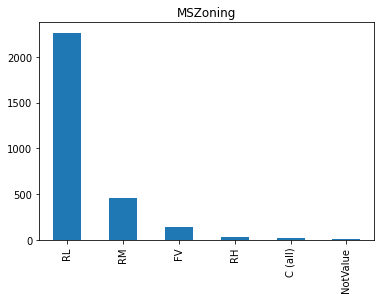

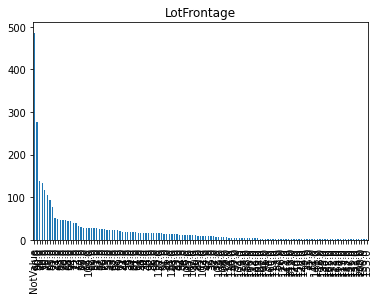

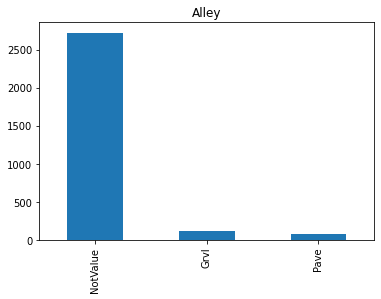

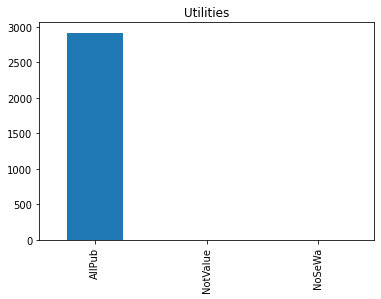

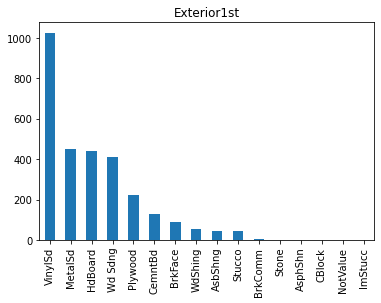

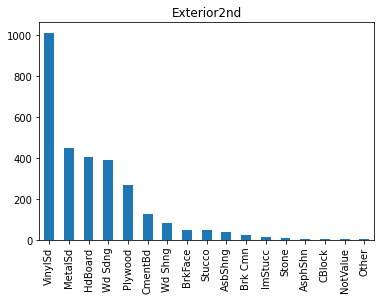

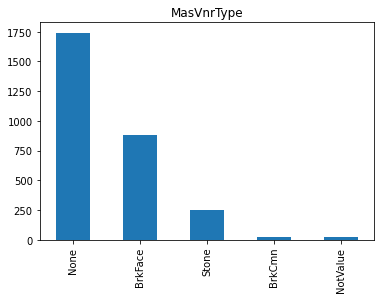

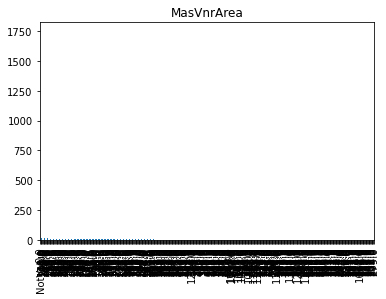

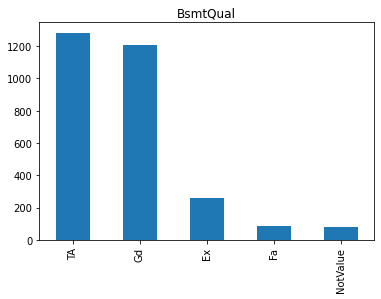

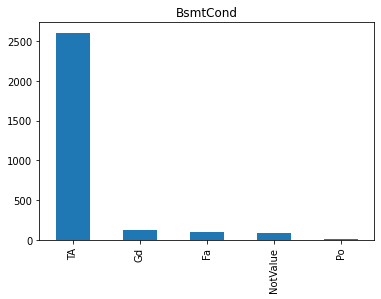

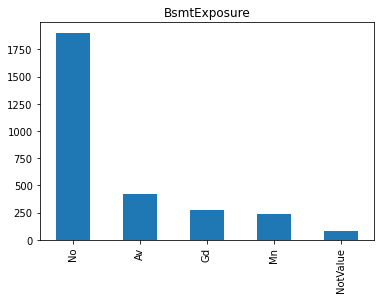

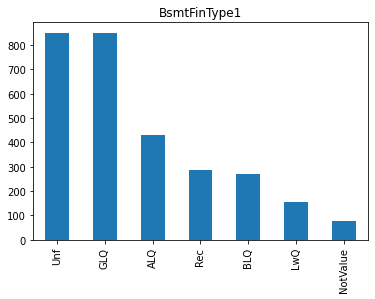

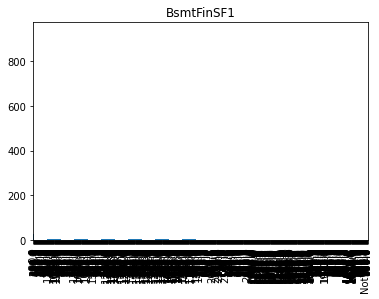

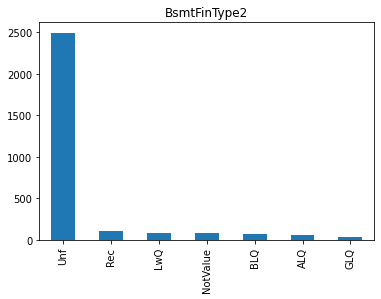

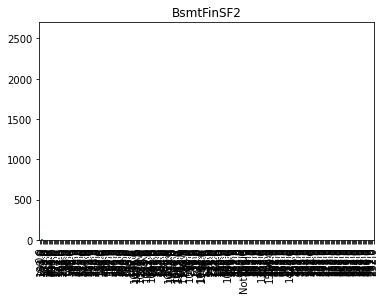

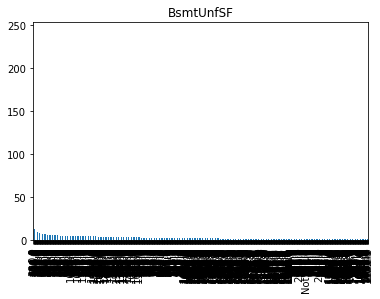

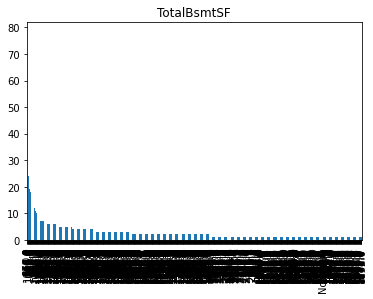

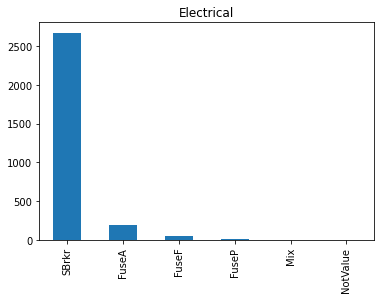

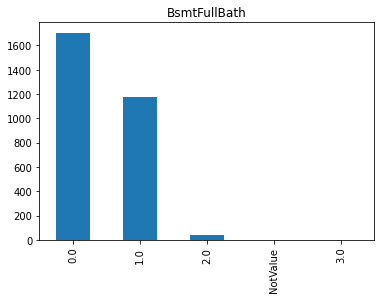

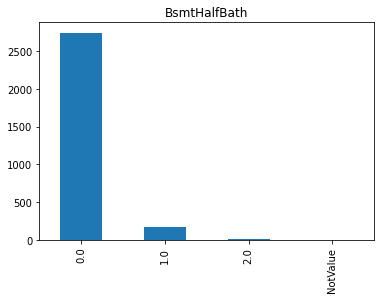

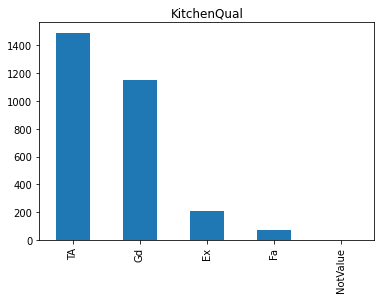

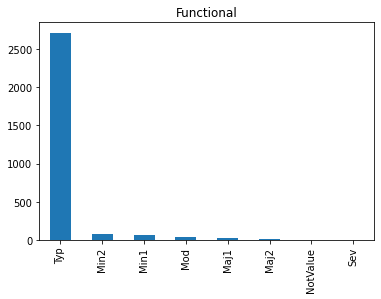

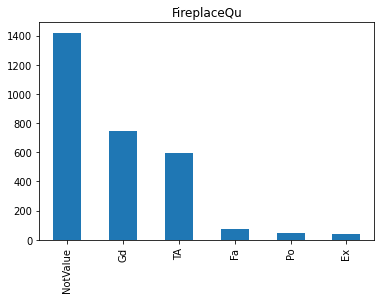

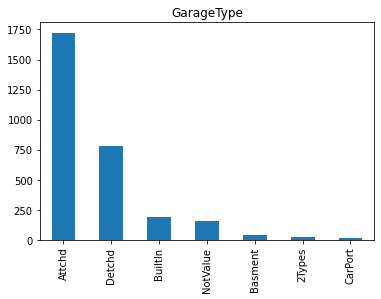

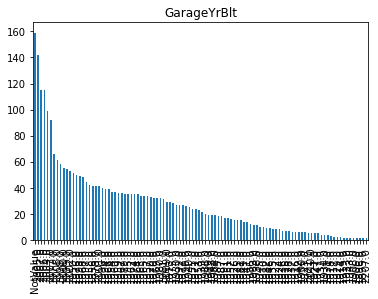

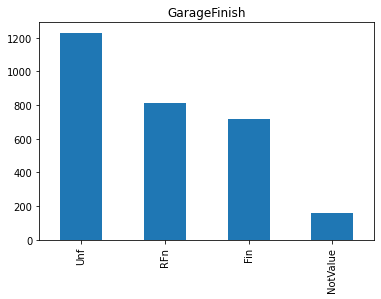

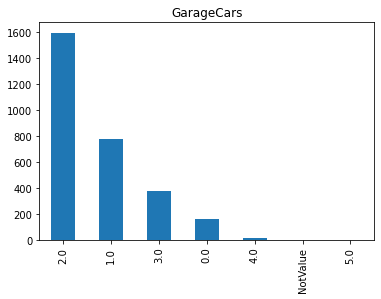

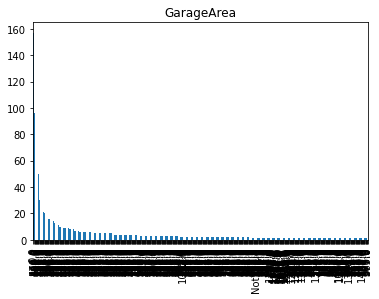

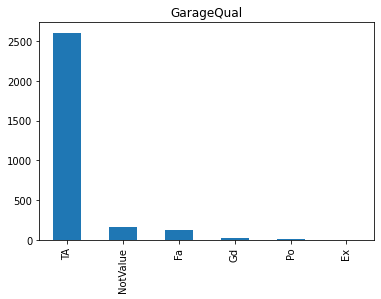

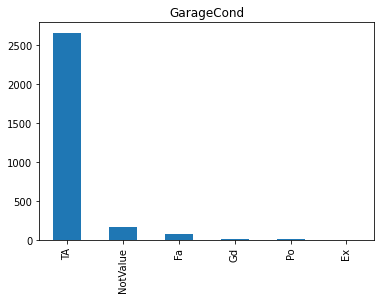

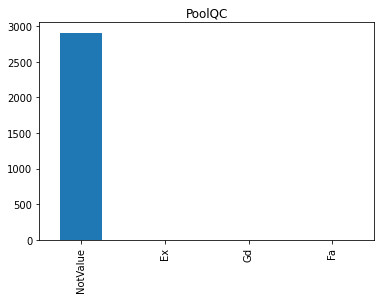

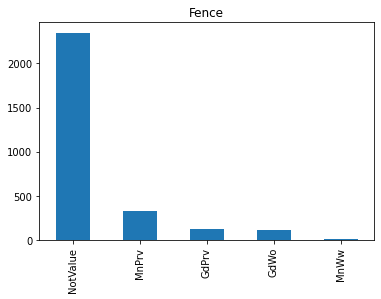

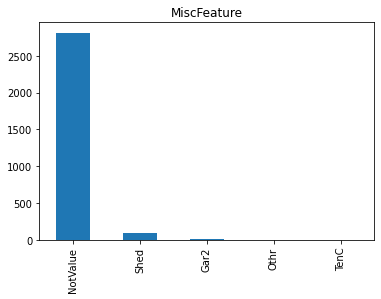

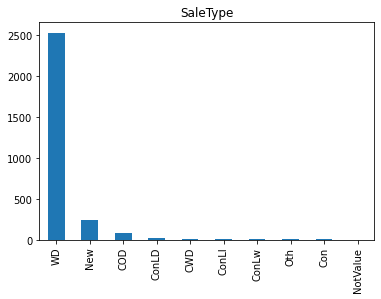

In [8]:
for feature in combined.columns:
  if combined[feature].isnull().any():
    print(feature, " has total of NaNs:\t\t", combined[feature].isnull().sum(), "\tout of:\t", combined.shape[0])
    fig, ax = plt.subplots()
    ax.set_title(feature)
    combined[feature].replace(float('NaN'), 'NotValue').value_counts().plot(ax=ax, kind='bar')

### Reemplazo de Missing Values/NAs

In [9]:
for feature in combined.columns:
  if combined[feature].isnull().any():
    print(feature)

MSZoning
LotFrontage
Alley
Utilities
Exterior1st
Exterior2nd
MasVnrType
MasVnrArea
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinSF1
BsmtFinType2
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
Electrical
BsmtFullBath
BsmtHalfBath
KitchenQual
Functional
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageCars
GarageArea
GarageQual
GarageCond
PoolQC
Fence
MiscFeature
SaleType


In [0]:
# Si son casas en el mismo vencindario, la distancia de la casa a la calle es casi, si no, la misma
combined["LotFrontage"] = combined.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# Si no tienen Garage, no tienen sentido que tengan un valor distinto de 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    combined[col] = combined[col].fillna(0)

# Si no tienen Sotano, no tienen sentido que tengan un valor distinto de 0
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    combined[col] = combined[col].fillna(0)

# Si es NA, es probable que no tenga
combined["MasVnrArea"] = combined["MasVnrArea"].fillna(0)

# Los siguientes features que tienen NA, se reemplazan por el valor más común; ese es el criterio utilizado
combined['MSZoning'] = combined['MSZoning'].fillna(combined['MSZoning'].mode()[0])


## Encoding

### Integer Encoding

In [0]:
# Function to Integer Encode

def integer_encode(ds, toEncode):
  ds[toEncode[0]] = ds[toEncode[0]].map({'Grvl': 0, 'Pave': 1})
  ds[toEncode[1]] = ds[toEncode[1]].map({'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 0})
  ds[toEncode[2]] = ds[toEncode[2]].map({'ELO': 0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 0})
  ds[toEncode[3]] = ds[toEncode[3]].map({'Gtl': 0, 'Mod': 1, 'Sev': 2})
  ds[toEncode[4]] = ds[toEncode[4]].map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})
  ds[toEncode[5]] = ds[toEncode[5]].map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})
  ds[toEncode[6]] = ds[toEncode[6]].map({float('NaN'): 0, 'Po': 1,'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
  ds[toEncode[7]] = ds[toEncode[7]].map({float('NaN'): 0, 'Po': 1,'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
  ds[toEncode[8]] = ds[toEncode[8]].map({float('NaN'): 0, 'No': 1,'Mn': 2, 'Av': 3, 'Gd': 4})
  ds[toEncode[9]] = ds[toEncode[9]].map({float('NaN'): 0, 'Unf': 1,'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6})
  ds[toEncode[10]] = ds[toEncode[10]].map({float('NaN'): 0, 'Unf': 1,'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6})
  ds[toEncode[11]] = ds[toEncode[11]].map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})
  ds[toEncode[12]] = ds[toEncode[12]].map({'N': 0, 'Y': 1})
  ds[toEncode[13]] = ds[toEncode[13]].map({float('NaN'): 1, 'SBrkr': 1, 'FuseA': 2, 'FuseF': 3, 'FuseP': 4, 'Mix': 5})
  ds[toEncode[14]] = ds[toEncode[14]].map({float('NaN'): 2, 'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})
  ds[toEncode[15]] = ds[toEncode[15]].map({float('NaN'): 8, 'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}) 
  # Data description says to assume tipical
  ds[toEncode[16]] = ds[toEncode[16]].map({float('NaN'): 0, 'Po': 1,'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
  ds[toEncode[17]] = ds[toEncode[17]].map({float('NaN'): 0, 'Unf': 1, 'RFn': 2, 'Fin': 3})
  ds[toEncode[18]] = ds[toEncode[18]].map({float('NaN'): 0, 'Po': 1,'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
  ds[toEncode[19]] = ds[toEncode[19]].map({float('NaN'): 0, 'Po': 1,'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
  ds[toEncode[20]] = ds[toEncode[20]].map({'N': 0, 'P': 1,'Y': 2})
  ds[toEncode[21]] = ds[toEncode[21]].map({float('NaN'): 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})
  ds[toEncode[22]] = ds[toEncode[22]].map({float('NaN'): 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4})

In [12]:
toIntegerEncode = ['Street', 'LotShape', 'Utilities', 'LandSlope',
                   'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                   'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
                   'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
                   'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
                   'PavedDrive', 'PoolQC', 'Fence'
                   ]

integer_encode(combined, toIntegerEncode)

combined[toIntegerEncode].isnull().any()

Street          False
LotShape        False
Utilities        True
LandSlope       False
ExterQual       False
ExterCond       False
BsmtQual        False
BsmtCond        False
BsmtExposure    False
BsmtFinType1    False
BsmtFinType2    False
HeatingQC       False
CentralAir      False
Electrical      False
KitchenQual     False
Functional      False
FireplaceQu     False
GarageFinish    False
GarageQual      False
GarageCond      False
PavedDrive      False
PoolQC          False
Fence           False
dtype: bool

### One Hot Encoding

In [0]:
def one_hot_encoding(ds, toEncode):
  for feature in toOneHotEncode:
    ds = pd.concat([ds,pd.get_dummies(ds[feature], prefix=feature)],axis=1)
  ds = ds.drop(columns=toOneHotEncode)
  return ds

In [14]:
toOneHotEncode = ['MSZoning', 'Alley', 'LandContour', 'LotConfig',
                  'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
                  'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                  'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
                  'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition'
                  ]

# Filling some NAs before One Hot Encode

# Son muy pocos NAs, estos se les asignara el valor mas comun
for feature in ('Exterior1st', 'Exterior2nd', 'SaleType'):
  combined[feature] = combined[feature].fillna(combined[feature].mode()[0])

combined = one_hot_encoding(combined, toOneHotEncode)


combined

,MSSubClass,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,...,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,1,0,0.0,0,7,5,2003,2003,196.0,3,2,4,3,1,6,706.0,1,0.0,150.0,856.0,4,1,1,856,854,0,1710,1.0,0.0,2,1,3,1,3,8,8,0,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,1,0,0.0,0,6,8,1976,1976,0.0,2,2,4,3,4,5,978.0,1,0.0,284.0,1262.0,4,1,1,1262,0,0,1262,0.0,1.0,2,0,3,1,2,6,8,1,...,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,1,2,0.0,0,7,5,2001,2002,162.0,3,2,4,3,2,6,486.0,1,0.0,434.0,920.0,4,1,1,920,866,0,1786,1.0,0.0,2,1,3,1,3,6,8,1,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,1,2,0.0,0,7,5,1915,1970,0.0,2,2,3,4,1,5,216.0,1,0.0,540.0,756.0,3,1,1,961,756,0,1717,1.0,0.0,1,0,3,1,3,7,8,1,...,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,1,2,0.0,0,8,5,2000,2000,350.0,3,2,4,3,3,6,655.0,1,0.0,490.0,1145.0,4,1,1,1145,1053,0,2198,1.0,0.0,2,1,4,1,3,9,8,1,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,21.0,1936,1,0,0.0,0,4,7,1970,1970,0.0,2,2,3,3,1,1,0.0,1,0.0,546.0,546.0,3,1,1,546,546,0,1092,0.0,0.0,1,1,3,1,2,5,8,0,...,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2915,160,21.0,1894,1,0,0.0,0,4,5,1970,1970,0.0,2,2,3,3,1,3,252.0,1,0.0,294.0,546.0,2,1,1,546,546,0,1092,0.0,0.0,1,1,3,1,2,6,8,0,...,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2916,20,160.0,20000,1,0,0.0,0,5,7,1960,1996,0.0,2,2,3,3,1,5,1224.0,1,0.0,0.0,1224.0,4,1,1,1224,0,0,1224,1.0,0.0,1,0,4,1,2,7,8,1,...,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2917,85,62.0,10441,1,0,0.0,0,5,5,1992,1992,0.0,2,2,4,3,3,6,337.0,1,0.0,575.0,912.0,2,1,1,970,0,0,970,0.0,1.0,1,0,3,1,2,6,8,0,...,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [15]:
for feature in combined.columns:
  if combined[feature].isnull().any():
    print(feature)

Utilities


## Detalles Finales

In [0]:
# No sirve este feature porque casi todos los datos en el dataset de test tienen un único
# valor, 2 son NA y 1 toma un valor distinto. Podemos botar esta columna
try: 
  combined = combined.drop(['Utilities'], axis=1) 
except:
  0


## Normalizando

In [17]:
def normalize_dataset(ds):
  for col in ds.columns:
    maxi = ds[col].max()
    mini = ds[col].min()
    ds[col] = (ds[col] - mini)/(maxi-mini)

# Normalizamos las columnas para disminuir el tiempo de entrenamiento y para mejor la capacidad del modelo para predecir
normalize_dataset(combined)
combined

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,...,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.235294,0.150685,0.033420,1.0,0.0,0.0,0.666667,0.500,0.949275,0.883333,0.12250,0.666667,0.5,0.8,0.75,0.25,1.000000,0.125089,0.166667,0.0,0.064212,0.140098,1.00,1.0,0.0,0.109641,0.413559,0.0,0.259231,0.333333,0.0,0.50,0.5,0.375,0.333333,0.666667,0.461538,1.0,0.00,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.038795,1.0,0.0,0.0,0.555556,0.875,0.753623,0.433333,0.00000,0.333333,0.5,0.8,0.75,1.00,0.833333,0.173281,0.166667,0.0,0.121575,0.206547,1.00,1.0,0.0,0.194917,0.000000,0.0,0.174830,0.000000,0.5,0.50,0.0,0.375,0.333333,0.333333,0.307692,1.0,0.25,0.6,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.235294,0.160959,0.046507,1.0,1.0,0.0,0.666667,0.500,0.934783,0.866667,0.10125,0.666667,0.5,0.8,0.75,0.50,1.000000,0.086109,0.166667,0.0,0.185788,0.150573,1.00,1.0,0.0,0.123083,0.419370,0.0,0.273549,0.333333,0.0,0.50,0.5,0.375,0.333333,0.666667,0.307692,1.0,0.25,0.6,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.294118,0.133562,0.038561,1.0,1.0,0.0,0.666667,0.500,0.311594,0.333333,0.00000,0.333333,0.5,0.6,1.00,0.25,0.833333,0.038271,0.166667,0.0,0.231164,0.123732,0.75,1.0,0.0,0.131695,0.366102,0.0,0.260550,0.333333,0.0,0.25,0.0,0.375,0.333333,0.666667,0.384615,1.0,0.25,0.8,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.215753,0.060576,1.0,1.0,0.0,0.777778,0.500,0.927536,0.833333,0.21875,0.666667,0.5,0.8,0.75,0.75,1.000000,0.116052,0.166667,0.0,0.209760,0.187398,1.00,1.0,0.0,0.170342,0.509927,0.0,0.351168,0.333333,0.0,0.50,0.5,0.500,0.333333,0.666667,0.538462,1.0,0.25,0.6,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,0.823529,0.000000,0.002973,1.0,0.0,0.0,0.333333,0.750,0.710145,0.333333,0.00000,0.333333,0.5,0.6,0.75,0.25,0.166667,0.000000,0.166667,0.0,0.233733,0.089362,0.75,1.0,0.0,0.044528,0.264407,0.0,0.142803,0.000000,0.0,0.25,0.5,0.375,0.333333,0.333333,0.230769,1.0,0.00,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## Separacion de Datasets

In [18]:
# Separamos los datasets en Train y Test
train = combined[:len_train]
test = combined[len_train:]

train = pd.concat([train, target], axis = 1)

train, test

(      MSSubClass  LotFrontage  ...  SaleCondition_Partial  SalePrice
 0       0.235294     0.150685  ...                    0.0     208500
 1       0.000000     0.202055  ...                    0.0     181500
 2       0.235294     0.160959  ...                    0.0     223500
 3       0.294118     0.133562  ...                    0.0     140000
 4       0.235294     0.215753  ...                    0.0     250000
 ...          ...          ...  ...                    ...        ...
 1455    0.000000     0.219178  ...                    0.0     210000
 1456    0.294118     0.154110  ...                    0.0     266500
 1457    0.000000     0.160959  ...                    0.0     142125
 1458    0.000000     0.184932  ...                    0.0     147500
 1459    0.000000     0.208904  ...                    0.0     137500
 
 [1460 rows x 216 columns],
       MSSubClass  LotFrontage  ...  SaleCondition_Normal  SaleCondition_Partial
 1460    0.000000     0.202055  ...              

## Distribucion de la variable explicada: SalePrice

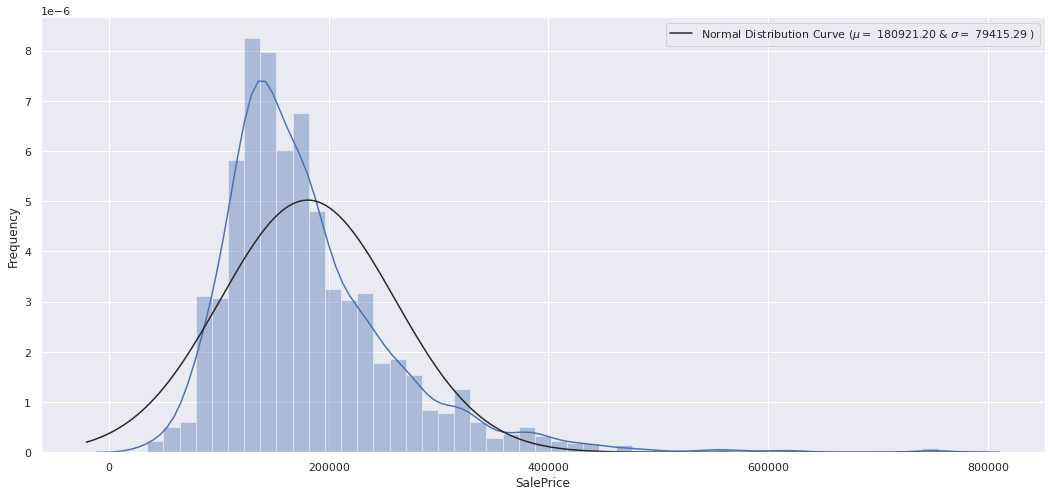

In [21]:
sns.set(rc={'figure.figsize':(18,8)})
sns.distplot(train['SalePrice'], fit=norm)

(mu, sig) = norm.fit(train['SalePrice'])
#Now plot the distribution
plt.legend(['Normal Distribution Curve ($\mu=$ {:.2f} & $\sigma=$ {:.2f} )'.format(mu, sig)])
plt.ylabel('Frequency')
plt.show()

### Transformación logarítmica

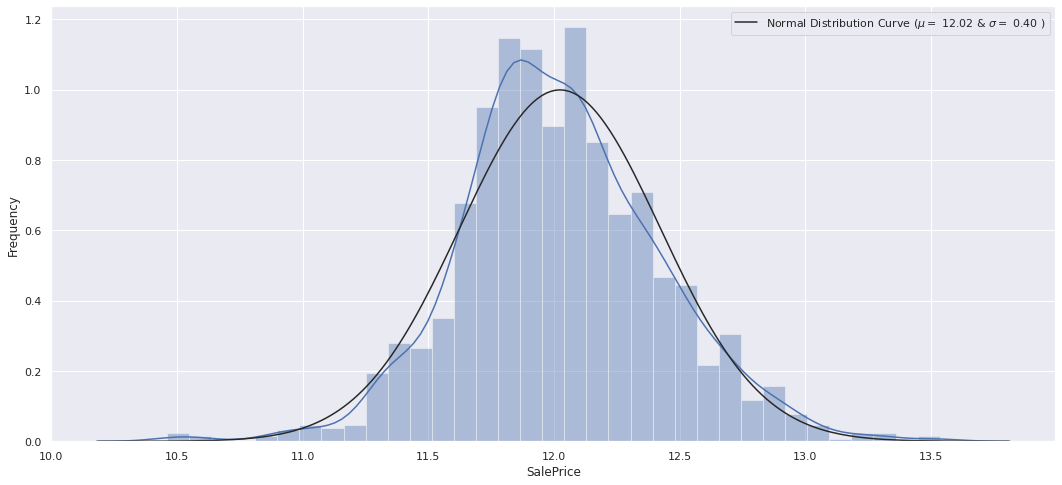

In [22]:
# Normalizando SalePrice utilizando log
train['SalePrice'] = np.log(train['SalePrice']+1)
sns.distplot(train['SalePrice'],fit=norm)

(mu, sig) = norm.fit(train['SalePrice'])
#Now plot the distribution
plt.legend(['Normal Distribution Curve ($\mu=$ {:.2f} & $\sigma=$ {:.2f} )'.format(mu, sig)])
plt.ylabel('Frequency')
plt.show()

## Correlacion

In [0]:
# Se extrae el grado de correlacion que tiene cada feature y se arma un mapa de Calor
corr = train.corr()
cols = corr.columns

### Mapa de de calor de Correlacion

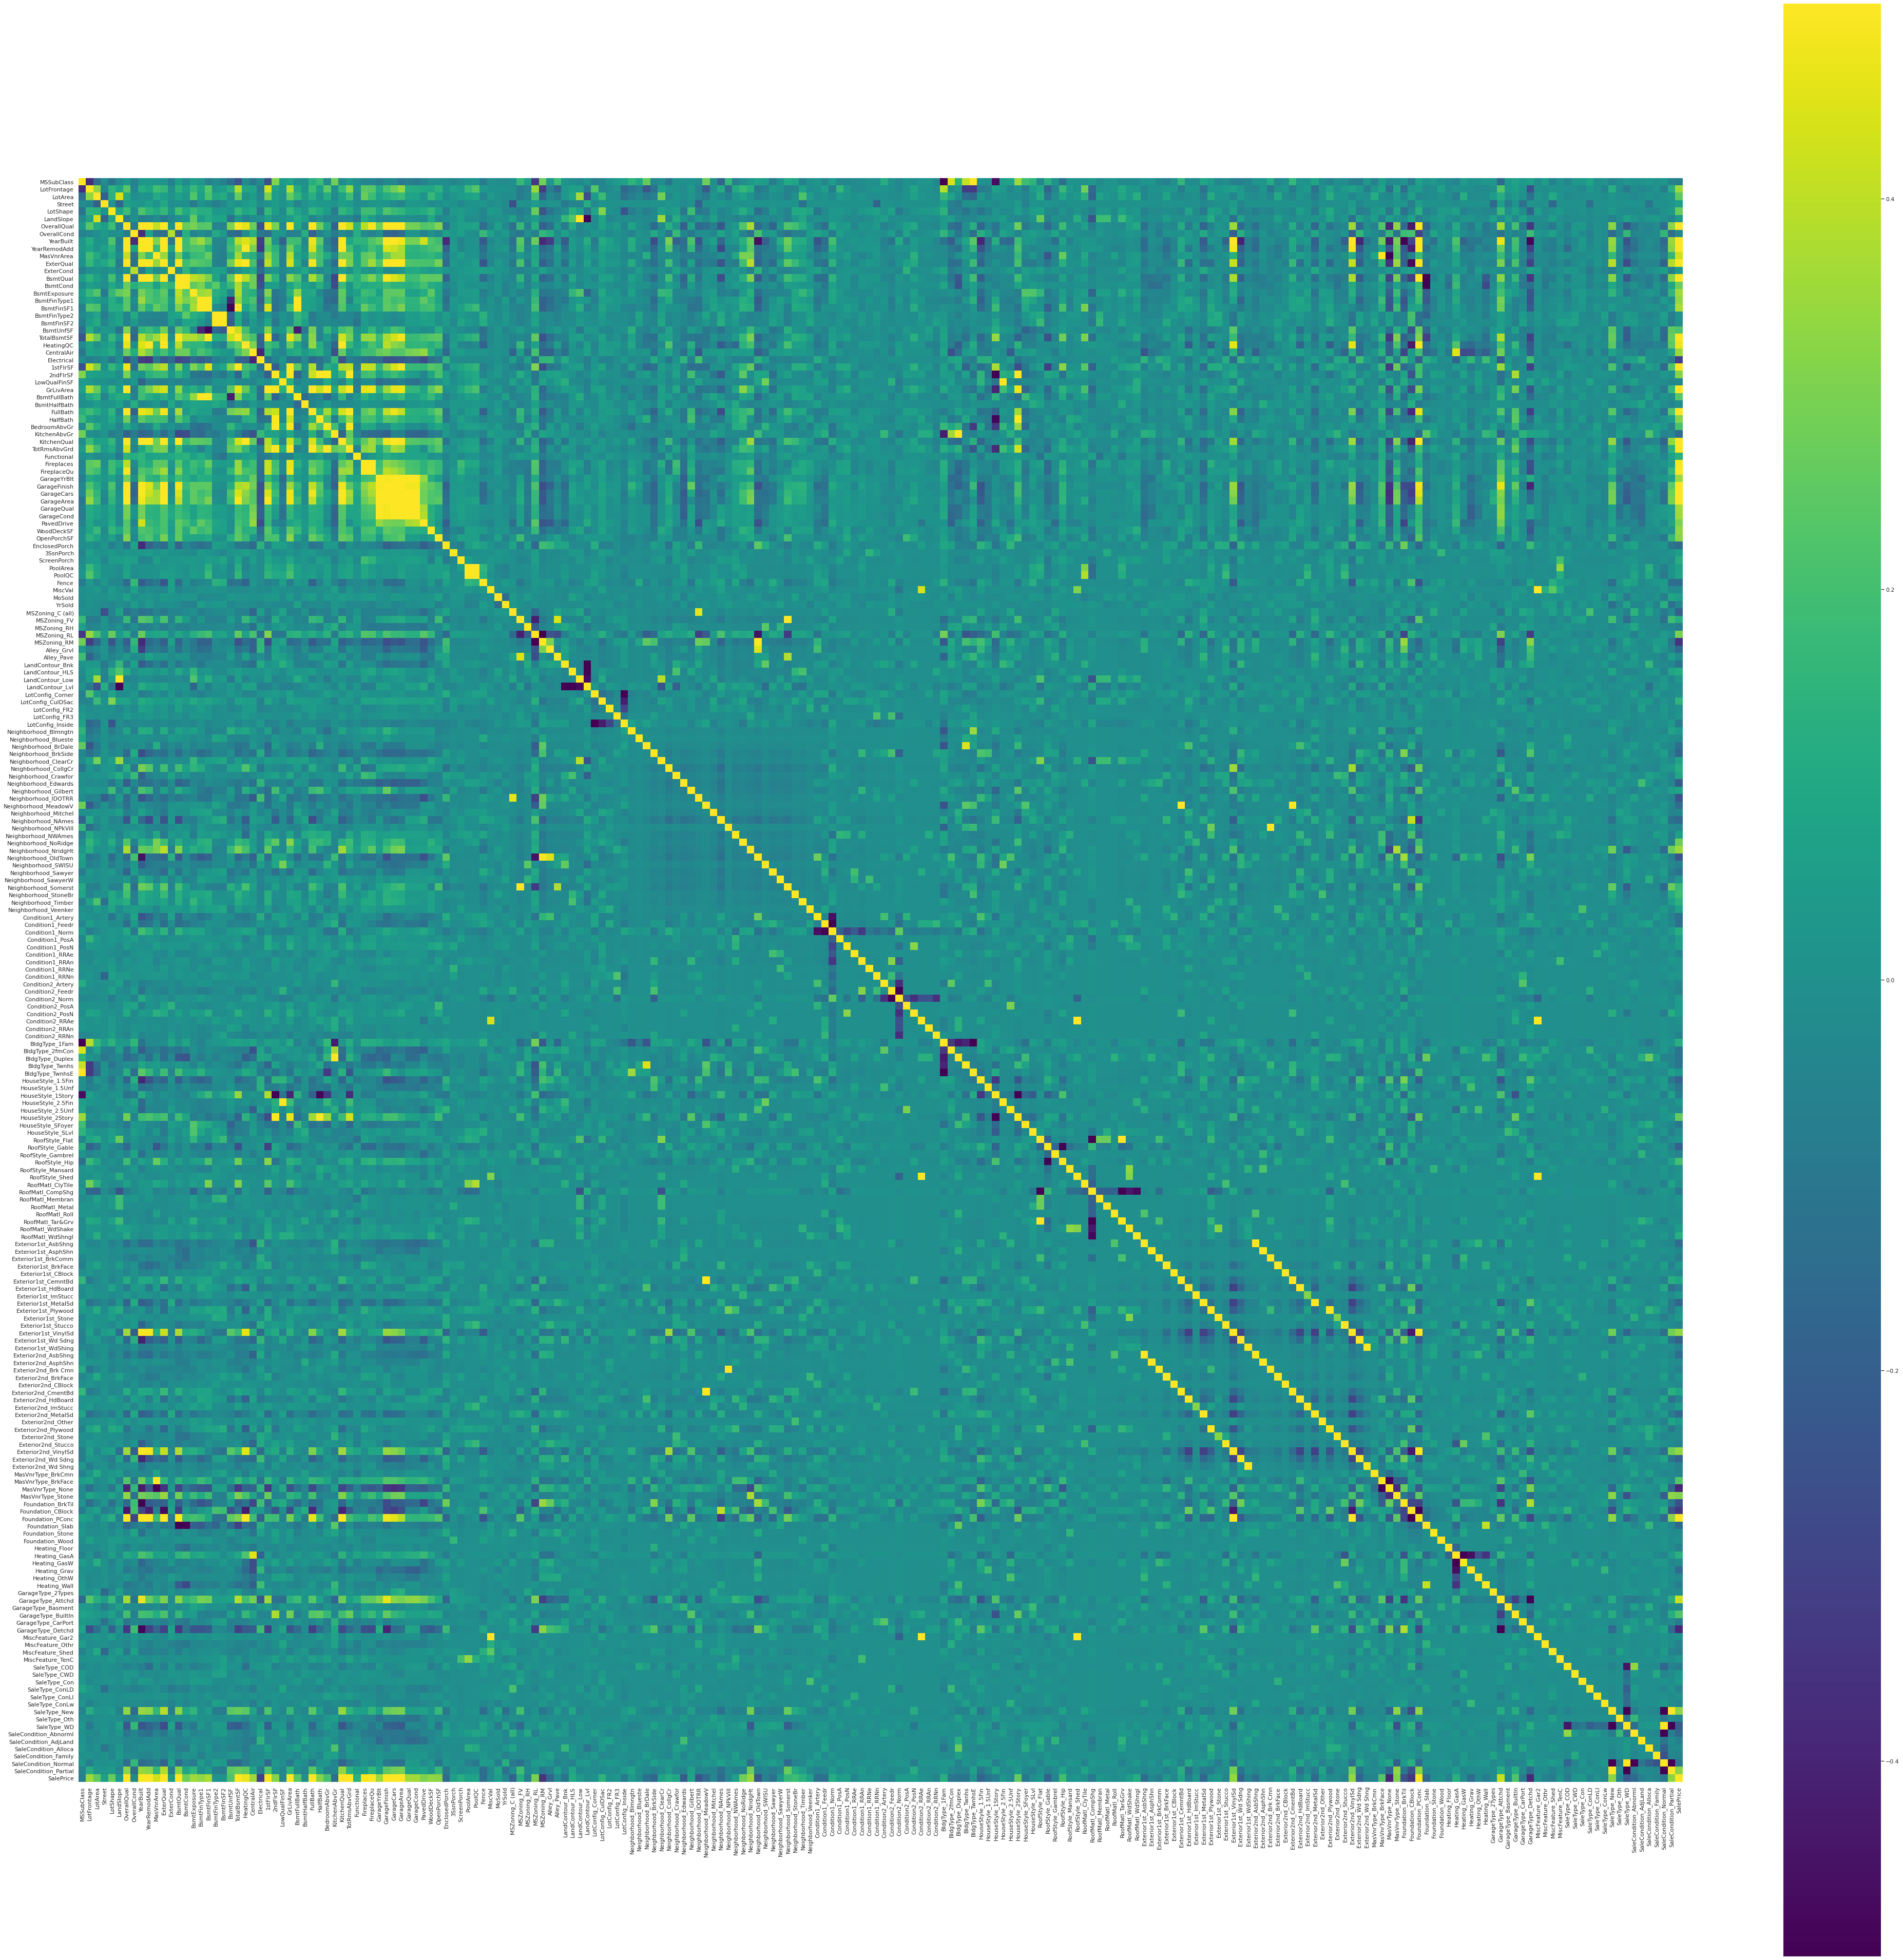

In [24]:
plt.figure(figsize=(70, 70))
sns.heatmap(corr, vmin=-0.5, vmax=0.5, square = True, cmap='viridis')

### Correlaciones de SalePrice
Se muestra cuanto cada feature se correlaciona con SalePrice

In [31]:
features = train.columns
corIndex = 0
for corFeat in corr['SalePrice']:
  print(features[corIndex], ":\t", corr['SalePrice'][corIndex])
  corIndex += 1

MSSubClass :	 -0.07395916536241472
LotFrontage :	 0.35123358943630095
LotArea :	 0.25732006506713967
Street :	 0.057369097812980344
LotShape :	 0.26936640273186924
LandSlope :	 0.038526195779039506
OverallQual :	 0.8171846144867618
OverallCond :	 -0.036868453834800495
YearBuilt :	 0.5865701927897148
YearRemodAdd :	 0.565607781462321
MasVnrArea :	 0.42677555810052276
ExterQual :	 0.6788402517304499
ExterCond :	 0.049313319238086
BsmtQual :	 0.6158037560867986
BsmtCond :	 0.27454273915755373
BsmtExposure :	 0.3574213757606112
BsmtFinType1 :	 0.3348025265869256
BsmtFinSF1 :	 0.37202325313636525
BsmtFinType2 :	 0.014033972222693562
BsmtFinSF2 :	 0.00483228639322613
BsmtUnfSF :	 0.2219851646403662
TotalBsmtSF :	 0.6121342283262255
HeatingQC :	 0.47376160428200564
CentralAir :	 0.3515994501578246
Electrical :	 -0.3008249384230106
1stFlrSF :	 0.5969813231855341
2ndFlrSF :	 0.31930013887847447
LowQualFinSF :	 -0.03796278590546489
GrLivArea :	 0.7009269871427164
BsmtFullBath :	 0.23622416084859

### Extraccion de Features importantes

In [32]:
'''
 Se establece un Threshold tanto Positivo como Negativo.
 Este Threshold se utiliza como criterio para identificar que features son importantes o no.
 
 Ejemplo:
 Threshold = 0.5
 Significa que todos los features que tengan un grado de correlación de 0.5 o mayor con SalePrice o de -0.5 o menor, se considera como
 feature importante
'''
importantFeatures = []
th = 0.0
thresholdP = th
thresholdN = -1 * th
corIndex = 0
for corFeat in corr['SalePrice']:
  if corFeat >= thresholdP or corFeat <= thresholdN:
    importantFeatures.append(features[corIndex])
    print(features[corIndex], ":\t", corr['SalePrice'][corIndex])
  corIndex += 1

importantFeatures

MSSubClass :	 -0.07395916536241472
LotFrontage :	 0.35123358943630095
LotArea :	 0.25732006506713967
Street :	 0.057369097812980344
LotShape :	 0.26936640273186924
LandSlope :	 0.038526195779039506
OverallQual :	 0.8171846144867618
OverallCond :	 -0.036868453834800495
YearBuilt :	 0.5865701927897148
YearRemodAdd :	 0.565607781462321
MasVnrArea :	 0.42677555810052276
ExterQual :	 0.6788402517304499
ExterCond :	 0.049313319238086
BsmtQual :	 0.6158037560867986
BsmtCond :	 0.27454273915755373
BsmtExposure :	 0.3574213757606112
BsmtFinType1 :	 0.3348025265869256
BsmtFinSF1 :	 0.37202325313636525
BsmtFinType2 :	 0.014033972222693562
BsmtFinSF2 :	 0.00483228639322613
BsmtUnfSF :	 0.2219851646403662
TotalBsmtSF :	 0.6121342283262255
HeatingQC :	 0.47376160428200564
CentralAir :	 0.3515994501578246
Electrical :	 -0.3008249384230106
1stFlrSF :	 0.5969813231855341
2ndFlrSF :	 0.31930013887847447
LowQualFinSF :	 -0.03796278590546489
GrLivArea :	 0.7009269871427164
BsmtFullBath :	 0.23622416084859

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'Street',
 'LotShape',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscVal',
 'MoSold',
 'YrSold',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Alley_Grvl',
 'Alley_Pave',
 'LandContour_Bnk',
 'LandContou

## Construccion del Nuevo Dataset de Entrenamiento

In [33]:
# Se utilizan el conjunto de features encontrados anteriormente para armar este nuevo dataset

datasetClean = train[importantFeatures]
datasetClean

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,...,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,0.235294,0.150685,0.033420,1.0,0.0,0.0,0.666667,0.500,0.949275,0.883333,0.122500,0.666667,0.50,0.8,0.75,0.25,1.000000,0.125089,0.166667,0.000000,0.064212,0.140098,1.00,1.0,0.00,0.109641,0.413559,0.0,0.259231,0.333333,0.0,0.50,0.5,0.375,0.333333,0.666667,0.461538,1.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.247699
1,0.000000,0.202055,0.038795,1.0,0.0,0.0,0.555556,0.875,0.753623,0.433333,0.000000,0.333333,0.50,0.8,0.75,1.00,0.833333,0.173281,0.166667,0.000000,0.121575,0.206547,1.00,1.0,0.00,0.194917,0.000000,0.0,0.174830,0.000000,0.5,0.50,0.0,0.375,0.333333,0.333333,0.307692,1.000000,0.25,0.6,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.109016
2,0.235294,0.160959,0.046507,1.0,1.0,0.0,0.666667,0.500,0.934783,0.866667,0.101250,0.666667,0.50,0.8,0.75,0.50,1.000000,0.086109,0.166667,0.000000,0.185788,0.150573,1.00,1.0,0.00,0.123083,0.419370,0.0,0.273549,0.333333,0.0,0.50,0.5,0.375,0.333333,0.666667,0.307692,1.000000,0.25,0.6,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.317171
3,0.294118,0.133562,0.038561,1.0,1.0,0.0,0.666667,0.500,0.311594,0.333333,0.000000,0.333333,0.50,0.6,1.00,0.25,0.833333,0.038271,0.166667,0.000000,0.231164,0.123732,0.75,1.0,0.00,0.131695,0.366102,0.0,0.260550,0.333333,0.0,0.25,0.0,0.375,0.333333,0.666667,0.384615,1.000000,0.25,0.8,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,11.849405
4,0.235294,0.215753,0.060576,1.0,1.0,0.0,0.777778,0.500,0.927536,0.833333,0.218750,0.666667,0.50,0.8,0.75,0.75,1.000000,0.116052,0.166667,0.000000,0.209760,0.187398,1.00,1.0,0.00,0.170342,0.509927,0.0,0.351168,0.333333,0.0,0.50,0.5,0.500,0.333333,0.666667,0.538462,1.000000,0.25,0.6,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.000000,0.219178,0.055505,1.0,0.0,0.0,0.555556,0.625,0.768116,0.633333,0.074375,0.333333,0.50,0.8,0.75,0.25,0.833333,0.139972,0.500000,0.106815,0.252140,0.252373,0.50,1.0,0.00,0.365259,0.000000,0.0,0.327619,0.333333,0.0,0.50,0.0,0.375,0.333333,0.333333,0.384615,0.833333,0.50,0.6,...,0.0,1.0,0.0,1.0,0.0,

### Particionamiento

In [0]:
# Se Particiona el Dataset de Train en: 80% de entrenamiento y 20% para testeo
dataTrain = datasetClean.sample(frac = 0.8)
dataTest = datasetClean.drop(dataTrain.index)

# Extrayendo valores a predecir
trainPredictions = dataTrain["SalePrice"]
testPredictions = dataTest["SalePrice"]

# Quitando la columna del dataset
dataTrain = dataTrain.drop(columns=['SalePrice'])
dataTest = dataTest.drop(columns=['SalePrice'])

# Modelo basado en Red Neuronal

## Callback
Son funciones que se ejecutan cada cierto tiempo o cuando se cumple una condicion mientras en la red neuronal se entrena

In [0]:
# Checkpoint Callback: Guarda el Mejor modelo
model_path = "/content/drive/My Drive/IO/Version2/Project/NN2/"
filepath = model_path + "saved_model.pb"
checkpoint_callback = ModelCheckpoint(filepath, monitor='mae', verbose=1, save_best_only=True, mode='min',save_freq='epoch')
#early_callback = EarlyStopping(monitor='mae', min_delta=0, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
# callbacks
callbacks_list = [checkpoint_callback] #, early_callback]

## Definicion del Modelo y Entrenamiento

In [36]:
epochs = 500
inputShape = dataTrain.shape[1]

# Training
model = Sequential([
      Dense(512, kernel_initializer='normal', activation='relu', input_shape=(inputShape,)),
      Dense(256, kernel_initializer='normal', activation='relu'),
      Dense(128, kernel_initializer='normal', activation='relu'),
      Dense(128, kernel_initializer='normal', activation='relu'),
      #Dropout(0.3),
      #Dense(128, kernel_initializer='normal', activation='relu'),
      #Dense(128, kernel_initializer='normal', activation='relu'),
      Dense(128, kernel_initializer='normal', activation='linear'),
      #Dropout(0.3),
      Dense(1)
  ])

model.compile(loss='mae', optimizer='adam', metrics=['mae'])


model.fit(dataTrain,
          trainPredictions,
          epochs=epochs,
          #validation_data=validation_split,
          batch_size = 32 ,
          validation_split=0.2,
          callbacks=callbacks_list
        )

Epoch 1/500
21/30 [====================>.........] - ETA: 0s - loss: 5.1739 - mae: 5.1739
Epoch 00001: mae improved from inf to 4.01916, saving model to /content/drive/My Drive/IO/Version2/Project/NN2/saved_model.pb
INFO:tensorflow:Assets written to: /content/drive/My Drive/IO/Version2/Project/NN2/saved_model.pb/assets
30/30 [==============================] - 1s 36ms/step - loss: 3.9299 - mae: 4.0192 - val_loss: 1.3026 - val_mae: 1.2697
Epoch 2/500
30/30 [==============================] - ETA: 0s - loss: 0.5781 - mae: 0.5874
Epoch 00002: mae improved from 4.01916 to 0.58741, saving model to /content/drive/My Drive/IO/Version2/Project/NN2/saved_model.pb
INFO:tensorflow:Assets written to: /content/drive/My Drive/IO/Version2/Project/NN2/saved_model.pb/assets
30/30 [==============================] - 1s 35ms/step - loss: 0.5781 - mae: 0.5874 - val_loss: 0.3531 - val_mae: 0.3536
Epoch 3/500
28/30 [===========================>..] - ETA: 0s - loss: 0.3060 - mae: 0.3060
Epoch 00003: mae improve

## Extrayendo el Mejor Modelo

In [37]:
# model_path = "/content/drive/My Drive/IO/Version1/Project/Normalized1/saved_model.pb"
model = tf.keras.models.load_model(filepath)

model.summary

<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f4fe70cd080>>

## Evaluacion del Modelo

In [38]:
model.evaluate(dataTest, testPredictions)

10/10 [==============================] - 0s 2ms/step - loss: 0.1050 - mean_absolute_error: 0.1073


[0.10500216484069824, 0.10728166997432709]

# Predicciones de Kaggle

In [0]:
try:
  importantFeatures.remove('SalePrice')
except:
  0
toPredict = test[importantFeatures]
predictions = np.expm1(model.predict(toPredict))

## Submission

In [40]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Id':IdPreds,'SalePrice':prediction})
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')
  return my_submission

make_submission(predictions[:,0],'HP_v2_tensorflow')

A submission file has been made


,Id,SalePrice
0,1461,137937.375000
1,1462,167659.359375
2,1463,197635.968750
3,1464,211509.031250
4,1465,192657.125000
...,...,...
1454,2915,86563.140625
1455,2916,89841.828125
1456,2917,156217.812500
1457,2918,108592.359375


# Resultados



1.   Modelo1:
    * Hidden Layers: 7 - [512, 256, 128, 128, 128, 128, 128, 1] {"normal"}
    * Threshold: 0.35
    * Epochs: 500
    * Batch Size: 32
    * Opt: Adam
    * Metrics: Mae
    * Loss: 0.10541658103466034
    * Kaggle Score: 0.18367

---


2.   Modelo 2:
    * Hidden Layers: 5 - [512, 256, 128, 128, 128, 1] {"normal"}
    * Threshold: 0.0
    * Epochs: 500
    * Batch Size: 32
    * Opt: Adam
    * Metrics: Mae
    * Loss: 0.10933761298656464
    * Kaggle Score: 0.16293
